In [0]:
from keras.models import load_model

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from tensorflow.python.keras import backend as Keras
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

**Approach 1** - Bounbed box and character recorgnizer

a) Loading the trained CNN

In [0]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import backend as  K

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation= 'relu', input_shape=(32,32,1)))

model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation= 'relu'))

model.add(Conv2D(64, (3, 3), activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(83, activation= 'softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

model.load_weights("/content/drive/My Drive/ECE1512_project/hand_written/models/CNN-classifier-1.hdf5")






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        36928    

Generating Image-Markup using image processing and trained CNN

In [0]:
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow

#function to find bounded box 
def bb_pred(img_path, max_box= None, k_gaus = None, k_dil = None, Vis = None):
  if(Vis == None):
    Vis = False
  
  if(max_box == None):
    max_box = 7
  
  if (k_gaus == None):
    k_gaus = (5, 5)
  else:
    k_gaus = (k_gaus, k_guas)
  
  if (k_dil == None):
    k_dil = np.ones((5, 5), np.uint8)
  else:
    k_dil = np.ones((k_dil, k_dil), np.uint8)

  img = cv.imread(img_path)
  img_grey = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  g_blur = cv.GaussianBlur(img_grey, k_gaus, 0)
  img_thres = cv.adaptiveThreshold(g_blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 11, 2)
  img_dil = cv.dilate(img_thres , k_dil, iterations = 1)
  (_, contours, hierarchy) = cv.findContours(img_dil, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE )
  Pseudo_attn = np.zeros((max_box, 4))
  c = 0
  X = []
  Y = []
  W = []
  H = []
  for contour in contours:
    (x,y,w,h) = cv.boundingRect(contour)
    X.append(x)
    Y.append(y)
    W.append(w)
    H.append(h)
    cv.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)
  if(Vis == True):
    cv2_imshow(img_grey)
    cv2_imshow(g_blur)
    cv2_imshow(img_thres)
    cv2_imshow(img_dil)
    cv2_imshow(img)
  X = np.array(X)
  Y = np.array(Y)
  W = np.array(W)
  H = np.array(H)
  ind = X.argsort()
  return X[ind], Y[ind], W[ind], H[ind]

Predicting the segments of original image

In [0]:
def centeread_reshaped(segment, Vis = None):
#Centering
  if(Vis == None):
    Vis = False
  segment = cv.resize(segment, (50, 50))
  centered = np.pad(segment[:, :, 0], ((5, 5), (5, 5)), 'maximum')
  #Rescaling these sectioned images for classification to CNN's input-size(32, 32, 1)
  centered_rescaled = cv.resize(centered, (32, 32))
  #cv2_imshow(centered_rescaled)
  if(Vis == True):
    cv2_imshow(centered_rescaled)
  return centered_rescaled

Reading the data-set and finding the exact matches and BLUE score

In [0]:
from skimage import transform,io
from skimage.filters import threshold_mean
def pred_cls(img):
  img = transform.resize(img, (32, 32), mode='symmetric', preserve_range=True)
  # threashold to convert it to binary
  thresh = threshold_mean(img)
  img_t = img > thresh
  img_t = img_t.reshape(1,32,32,1)
  pred = model.predict_classes(img_t)
  classes = ['=', '-', ',', '!', '(', ')', '[', ']', '{', '}', '+', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'alpha', 'ascii_124', 'b', 'beta', 'C', 'cos', 'd', 'Delta', 'div', 'e', 'exists', 'f', 'forall', 'forward_slash', 'G', 'gamma', 'geq', 'gt', 'H', 'i', 'in', 'infty', 'int', 'j', 'k', 'l', 'lambda', 'ldots', 'leq', 'lim', 'log', 'lt', 'M', 'mu', 'N', 'neq', 'o', 'p', 'phi', 'pi', 'pm', 'prime', 'q', 'R', 'rightarrow', 'S', 'sigma', 'sin', 'sqrt', 'sum', 'T', 'tan', 'theta', 'times', 'u', 'v', 'w', 'X', 'y', 'z', '']
  pred_cls = []
  return(classes[pred[0]])

In [0]:
#loading the data-set
root_dir = "/content/drive/My Drive/ECE1512_project/hand_written/eqn"
#Reading the training data file_name and gt_formulas
train_f = "groundtruth_train.tsv"
f1 = open(os.path.join(root_dir, train_f))

file_name = []
formulas = []
max_len = 0
for line in f1:
  if len(line.split('\t')) == 2:
    file_name.append(os.path.join(os.path.join(root_dir, 'train'), (line.split('\t')[0] + '.png')))
    dummy = line.split('\t')[1]
    formulas.append(dummy.replace('_', ' _ ').replace('^', ' ^ ').replace('\n', ' ').replace('\t', ' ').replace('{', ' { ').replace('}', ' } ').replace('(', ' ( ').replace(')', ' ) ').replace('=', ' = ').replace('+', ' + ').replace('-', ' - ').replace('\\', ' \\').replace(',', ' , ').replace('~', ' '))
    max_len = max(len(dummy), max_len)


In [0]:
pred_form = []
for i in range(0, len(file_name)):
  img = cv.imread(file_name[i])
  GT_formula = (formulas[i]).split(' ')
  x, y, w, h = bb_pred(file_name[i])
  pred_len = len(x)
  pred = []
  #cv2_imshow(img) 
  for i in range(0, len(x)):
    segment = img[y[i]:(y[i]+h[i]), x[i]:(x[i]+w[i])]
    #cv2_imshow(segment)
    #print(np.shape(segment))
    segment = centeread_reshaped(segment)
    pred.append(pred_cls(segment))
  pred_form.append("".join(pred))
  #print('Predicted Fromula: ' + " ".join(pred))
  #print('Actual Formula: ' + formulas[i]+ '\n')

In [0]:
#import fuzzywuzzy as fuzz
#similarity_score = []
#similarity_score_wo_ordering = []
#simialrity_just_matching_tokens = []
import nltk
dist_closeness = []
blue = []
for i in range(0, len(pred_form)):
#  similarity_score.append(fuzz.partial_ratio(formulas[i], pred_form[i]))
#  similarity_score_wo_ordering.append(fuzz.token_sort_ratio(formulas[i], pred_form[i]))
#  similarity_just_matching_tokens.append(fuzz.token_set_ratio(formulas[i], pred_form[i]))
  dist_closeness.append(nltk.edit_distance(pred_form[i], formulas[i]))
  BLEUscore = nltk.translate.bleu_score.sentence_bleu([formulas[i]], pred_form[i])
  blue.append(BLEUscore)

In [0]:
print("Average Distance between the formulas on embedding: {}".format(np.average(dist_closeness)))
print("Average Similarity of Formulas: {}".format(np.average(blue)))

Average Distance between the formulas on embedding: 60.05781990521327
Average Similarity of Formulas: 0.036273865210252235


Some easy pics for visualization

In [0]:
check_dir = "/content/drive/My Drive/ECE1512_project/hand_written/eqn/easy_visualization"
images = os.listdir(check_dir)
check_formulas = ['x + y', 'q times p', '7 times 7', 'A times A', 'x neq y', 'sum 1 = infty' , 'y gt x', 'p = sum p', '+ C . C' , 'phi in S ', 'sigma in G', 'H in P', 'sigma in X']
images

['rit_4265_1.png',
 '103_em_19.png',
 'UN_465_em_969.png',
 'UN_123_em_513.png',
 'UN_462_em_895.png',
 'UN_465_em_973.png',
 'UN_453_em_651.png',
 'UN_130_em_1069.png',
 'UN_102_em_30.png',
 '9_em_76.png',
 '8_em_62.png',
 '9_em_77.png',
 '10_em_87.png']

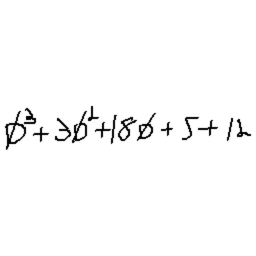

Predicted Fromula: tan + pi lim
Actual Formula: phi ^ 3 + 3 phi ^ 2 + 18 phi + 5 + 12



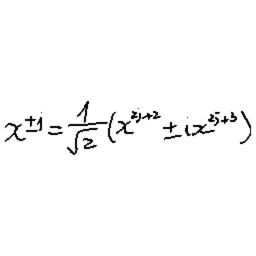

Predicted Fromula: X M j
Actual Formula: x ^ { \pm j } = \frac { 1 } { \sqrt{ 2 } } (x ^ { 2 j + 2 } \pm j x ^ { 2 j + 3 } )



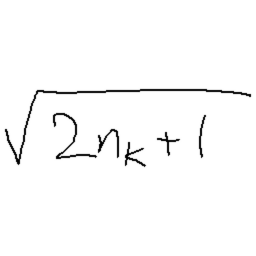

Predicted Fromula: pi lim + p
Actual Formula: \sqrt { 2 n _ k + 1 }



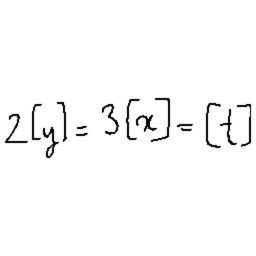

Predicted Fromula: cos sum 3 pi M sin log pi N
Actual Formula: 2 [ y ] = 3 [ x ] = [ t ]



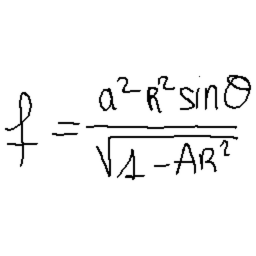

Predicted Fromula: f log tan lim A d q tan j theta
Actual Formula: f = \frac { a ^ 2 R ^ 2 sin \theta } { \sqrt{ 1 - A R ^ 2 } }



In [0]:
chck_pred_form = []

for i in range(0, len(images)):
  img = cv.imread(os.path.join(check_dir, images[i]))
  x, y, w, h = bb_pred(os.path.join(check_dir, images[i]))
  pred_len = len(x)
  pred = []
  cv2_imshow(img) 
  for j in range(0, len(x)):
    segment = img[y[j]:(y[j]+h[j]), x[j]:(x[j]+w[j])]
    #print(np.shape(segment))
    segment = centeread_reshaped(segment)
    #cv2_imshow(segment)
    pred.append(pred_cls(segment))
  chck_pred_form.append("".join(pred))
  print('Predicted Fromula: ' + " ".join(pred))
  print('Actual Formula: ' + check_formulas[i]+ '\n')



In [0]:
check_dir = "/content/drive/My Drive/ECE1512_project/hand_written/eqn/difficult"
images = os.listdir(check_dir)
check_formulas = ['phi ^ 3 + 3 phi ^ 2 + 18 phi + 5 + 12', 'x ^ { \pm j } = \\frac { 1 } { \sqrt{ 2 } } (x ^ { 2 j + 2 } \pm j x ^ { 2 j + 3 } )', '\sqrt { 2 n _ k + 1 }', '2 [ y ] = 3 [ x ] = [ t ]', 'f = \\frac { a ^ 2 R ^ 2 sin \\theta } { \sqrt{ 1 - A R ^ 2 } }']
images

['rit_42190_2.png',
 'UN_102_em_43.png',
 'UN_105_em_111.png',
 'UN_459_em_815.png',
 'UN_118_em_392.png']

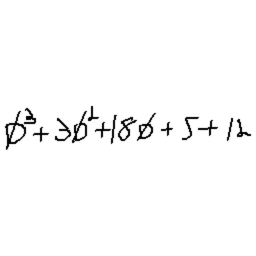

Predicted Fromula: phi + X 4 X d + X + p R
Actual Formula: phi ^ 3 + 3 phi ^ 2 + 18 phi + 5 + 12



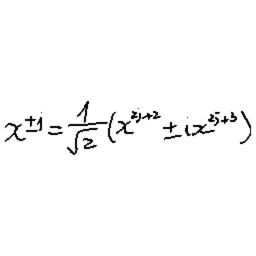

Predicted Fromula: X = tan z - pm X j y
Actual Formula: x ^ { \pm j } = \frac { 1 } { \sqrt{ 2 } } (x ^ { 2 j + 2 } \pm j x ^ { 2 j + 3 } )



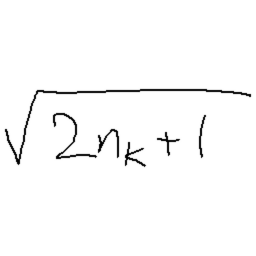

Predicted Fromula: pi lim k + 6
Actual Formula: \sqrt { 2 n _ k + 1 }



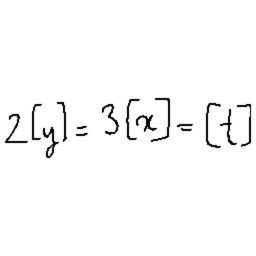

Predicted Fromula: 4 X log phi 3 pi M A log C 1 1
Actual Formula: 2 [ y ] = 3 [ x ] = [ t ]



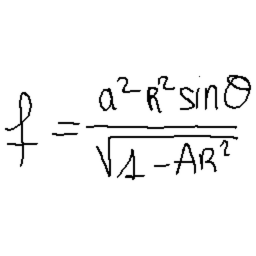

Predicted Fromula: f log tan tan lim A d 2 pi log G phi j N theta
Actual Formula: f = \frac { a ^ 2 R ^ 2 sin \theta } { \sqrt{ 1 - A R ^ 2 } }



In [0]:
chck_pred_form = []

for i in range(0, len(images)):
  img = cv.imread(os.path.join(check_dir, images[i]))
  x, y, w, h = bb_pred(os.path.join(check_dir, images[i]), k_dil = 3)
  pred_len = len(x)
  pred = []
  cv2_imshow(img) 
  for j in range(0, len(x)):
    segment = img[y[j]:(y[j]+h[j]), x[j]:(x[j]+w[j])]
    #print(np.shape(segment))
    segment = centeread_reshaped(segment)
    #cv2_imshow(segment)
    pred.append(pred_cls(segment))
  chck_pred_form.append("".join(pred))
  print('Predicted Fromula: ' + " ".join(pred))
  print('Actual Formula: ' + check_formulas[i]+ '\n')

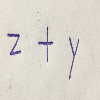

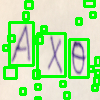

(array([ 3,  4,  8,  9, 20, 23, 25, 33, 35, 35, 35, 37, 41, 60, 64, 69, 76,
        84, 88, 90, 92, 94, 95, 95]),
 array([45, 67, 35, 22, 88, 12,  1, 70, 36, 97, 84, 33, 26, 81, 92, 39, 18,
         0, 66, 12, 85, 77, 70, 57]),
 array([ 5, 12,  6, 24,  5,  5,  7,  6,  7,  5,  5, 28,  5,  5,  5, 19,  5,
        10,  5,  5,  5,  5,  5,  5]),
 array([ 5, 11,  6, 43,  6,  7,  7,  8,  7,  3,  5, 43,  5,  5,  6, 38,  6,
         6,  5,  5,  5,  7,  5,  8]))

In [0]:
check_dir = "/content/drive/My Drive/ECE1512_project/hand_written/eqn/real_images"
real_images = os.listdir(check_dir)
img = cv.imread(os.path.join(check_dir, real_images[0]))
img = cv.resize(img, (100, 100))
cv2_imshow(img)
bb_pred(os.path.join(check_dir, images[i]), Vis = True)
#Need to adjust the bb function for the real pic

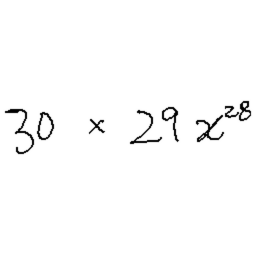

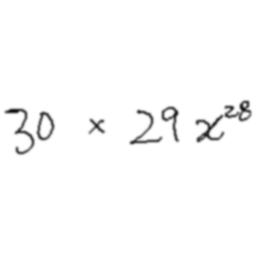

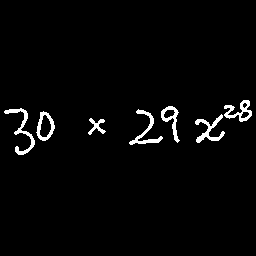

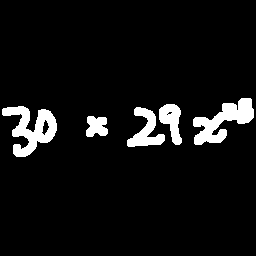

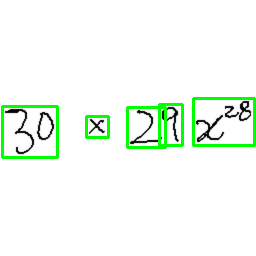

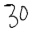

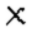

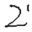

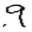

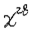

In [0]:
idx = 293
img = cv.imread(file_name[idx])
x, y, w, h = bb_pred(file_name[idx], Vis = True)
pred_len = len(x)
#cv2_imshow(img) 
for i in range(0, len(x)):
  segment = img[y[i]:(y[i]+h[i]), x[i]:(x[i]+w[i])]
  #cv2_imshow(segment)
  #print(np.shape(segment))
  segment = centeread_reshaped(segment, Vis = True)
